# Loading dataset and performing basic stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import random
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier

import dataframe_image as dfi

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv' , encoding='latin-1', header=None , usecols=[0,5])
df.columns = ['sentiment' , 'text']
df = df[['text' , 'sentiment']]
df.head(10)

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
5,@Kwesidei not the whole crew,0
6,Need a hug,0
7,@LOLTrish hey long time no see! Yes.. Rains a...,0
8,@Tatiana_K nope they didn't have it,0
9,@twittera que me muera ?,0


In [3]:
dfi.export(df, 'dataframe.png', max_rows=10)

In [5]:
df.columns

Index(['text', 'sentiment'], dtype='object')

In [6]:
def sentiment_conversion(x):
    if x==0:
        return "negative"
    elif x==2:
        return "neutral"
    else:
        return "positive"

In [7]:
df['sentiment'] = df.sentiment.apply(sentiment_conversion)

In [8]:
df.shape

(1600000, 2)

In [9]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [10]:
df.dtypes

text         object
sentiment    object
dtype: object

# Tokenizing

In [11]:
df.loc[1][0]

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

In [12]:
# Reformatting dataset to list of tuples, each tuple has 2 elements, 1st is list of words and 2nd is its category

documents = []
for i in range(len(df)):
    category = df.loc[i][1]
    words = word_tokenize(df.loc[i][0])
    documents.append((words , category))
documents[0:2]

[(['@',
   'switchfoot',
   'http',
   ':',
   '//twitpic.com/2y1zl',
   '-',
   'Awww',
   ',',
   'that',
   "'s",
   'a',
   'bummer',
   '.',
   'You',
   'shoulda',
   'got',
   'David',
   'Carr',
   'of',
   'Third',
   'Day',
   'to',
   'do',
   'it',
   '.',
   ';',
   'D'],
  'negative'),
 (['is',
   'upset',
   'that',
   'he',
   'ca',
   "n't",
   'update',
   'his',
   'Facebook',
   'by',
   'texting',
   'it',
   '...',
   'and',
   'might',
   'cry',
   'as',
   'a',
   'result',
   'School',
   'today',
   'also',
   '.',
   'Blah',
   '!'],
  'negative')]

In [13]:
len(documents)

1600000

In [14]:
# shuffling documents
random.shuffle(documents)

# creating list of stopwords

In [15]:
stops = stopwords.words('english') + list(string.punctuation)

# Lemmatizing

In [16]:
lemmatizer = WordNetLemmatizer()

In [17]:
# defining fuction to convert part of speech into simple part of speech so that wordLemmatizer can understand

def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [18]:
# function to remove no.'s from the feature vocabulary

def NotNumber(w):
    for ch in w:
        if(ch>='0' and ch<='9'):
            return False
    return True

In [19]:
# defining function to make the list of words clear 

def clean_review(words):
    output_words = []
    for w in words:
        if w.lower() not in stops and NotNumber(w)==True:
            pos = pos_tag([w])                                 
            clean_word = lemmatizer.lemmatize(w, get_simple_pos(pos[0][1]))
            output_words.append(clean_word.lower())
    return output_words

In [20]:
# Creating clear documents

start = time.time()
documents = [(clean_review(document), category) for document, category in documents]
end = time.time()
print("Cleaning time: ", end - start)

Cleaning time:  6502.861960887909


In [21]:
documents[0]

(['yes', 'could', 'hopefully', "'ve", 'drop', 'lb', 'next', 'week', '....'],
 'positive')

In [22]:
# again reformatting dataset in the form of of  x and y, so as to feed it to sklearn classifiers

categories = [category for document, category in documents]
text_documents = [" ".join(document) for document, category in documents]

In [23]:
# train - test split

X_train, X_test, y_train, y_test = train_test_split(text_documents, categories , random_state=1 , test_size=0.2)

# using TfidfVectorizer and applying different algos

In [24]:
tfidf = TfidfVectorizer()
X_train_t = tfidf.fit_transform(X_train)
X_test_t = tfidf.transform(X_test)

In [25]:
import pickle as pkl

with open('transform.pkl', 'wb') as f:
    pkl.dump(tfidf, f)

In [23]:
alg1 = LogisticRegression()

start = time.time()
alg1.fit(X_train_t , y_train)
end = time.time()
total_time1 = end - start

y_pred1 = alg1.predict(X_test_t)

print('accuracy : ', alg1.score(X_test_t , y_test))
print('time : ' , total_time1)

accuracy :  0.7789875
time :  29.94295334815979


In [24]:
alg3 = DecisionTreeClassifier(max_depth=4 , criterion='gini')

start = time.time()
alg3.fit(X_train_t , y_train)
end = time.time()
total_time3 = end - start

y_pred3 = alg3.predict(X_test_t)

print('accuracy : ', alg3.score(X_test_t , y_test))
print('time : ' , total_time3)

accuracy :  0.538075
time :  14.146321773529053


In [26]:
alg4 = BernoulliNB()

start = time.time()
alg4.fit(X_train_t,y_train)
end = time.time()
total_time4 = end - start

y_pred4 = alg4.predict(X_test_t)

print('accuracy : ', alg4.score(X_test_t , y_test))
print('time : ' , total_time4)

accuracy :  0.770675
time :  2.423398733139038


In [26]:
alg6 = MultinomialNB()

start = time.time()
alg6.fit(X_train_t,y_train)
end = time.time()
total_time6 = end - start

y_pred6 = alg6.predict(X_test_t)

print('accuracy : ', alg6.score(X_test_t , y_test))
print('time : ' , total_time6)

accuracy :  0.761478125
time :  1.5269100666046143


In [33]:
alg9 = LinearSVC(multi_class='crammer_singer')

start = time.time()
alg9.fit(X_train_t, y_train)
end = time.time()
total_time9 = end - start

y_pred9 = alg9.predict(X_test_t)

print('accuracy : ', alg9.score(X_test_t , y_test))
print('time : ' , total_time9)

accuracy :  0.777421875
time :  1214.346406698227


In [29]:
alg10 = RidgeClassifier()

start = time.time()
alg10.fit(X_train_t, y_train)
end = time.time()
total_time10 = end - start

y_pred10 = alg10.predict(X_test_t)

print('accuracy : ', alg10.score(X_test_t , y_test))
print('time : ' , total_time10)

accuracy :  0.774009375
time :  15.903161525726318


In [ ]:
df_model=pd.DataFrame({
'Model_Applied':['Logistic_Regression', 'Decision_tree', 'BernoulliNB',  'MultinomialNB', 'Linear_SVC', 'Ridge_Classifier'],
'Accuracy':[alg1.score(X_test_t,y_test), alg3.score(X_test_t,y_test), alg4.score(X_test_t,y_test), alg6.score(X_test_t,y_test),
            alg9.score(X_test_t,y_test), alg10.score(X_test_t,y_test)],
'Training_Time':[total_time1, total_time3, total_time4, total_time6, total_time9, total_time10]})

In [3]:
df_model

,Model_Applied,Accuracy,Training_Time
0,Logistic_Regression,77.89,29.94
1,Decision_tree,53.80,14.14
2,BernoulliNB,77.05,1.64
3,MultinomialNB,76.14,1.52
4,Linear_SVC,77.74,1214.34
5,Ridge_Classifier,77.40,15.90


In [26]:
dfi.export(df_model, 'df_model.png')

<AxesSubplot:title={'center':'Accurcy comparison of different Models'}, xlabel='Model_Applied', ylabel='Accuracy'>

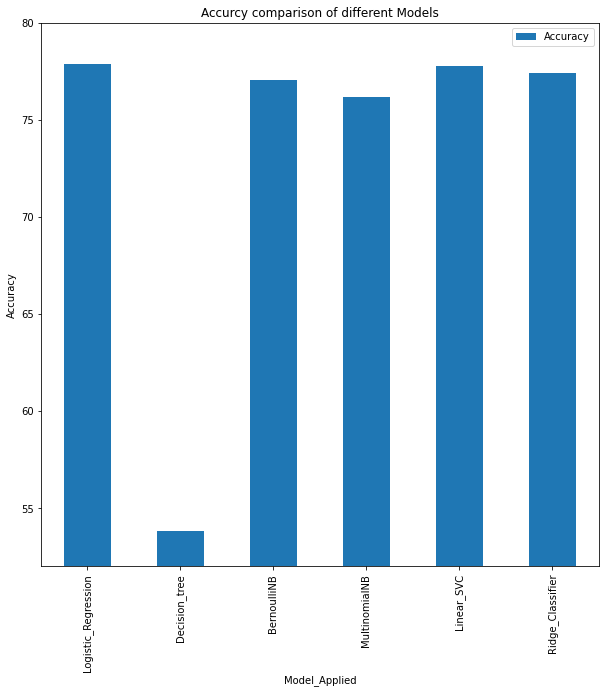

In [12]:
df_model.plot(kind='bar',x='Model_Applied', ylim=[52,80] , y='Accuracy', figsize=(10,10) , ylabel='Accuracy', title='Accurcy comparison of different Models')

<AxesSubplot:title={'center':'Training time comparison of different Models'}, xlabel='Model_Applied', ylabel='Training Time'>

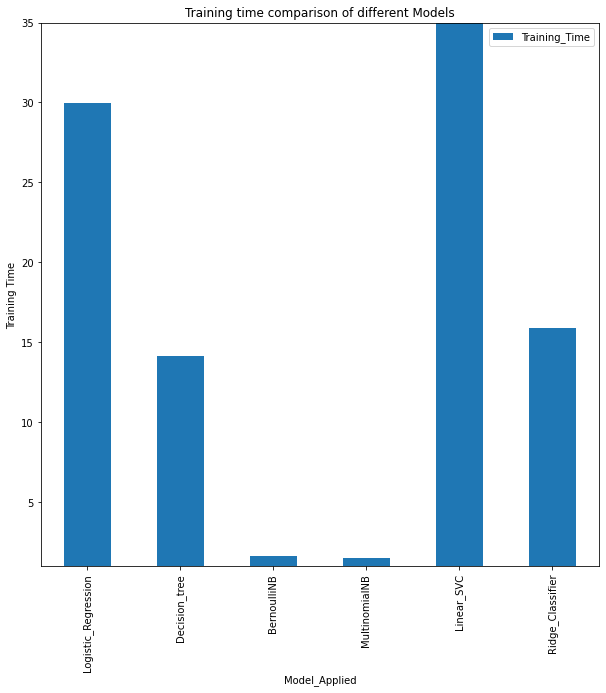

In [14]:
df_model.plot(kind='bar',x='Model_Applied', ylim=[1.0,35] , y='Training_Time', figsize=(10,10), ylabel='Training Time', title='Training time comparison of different Models')

In [27]:
import pickle as pkl

with open('model.pkl', 'wb') as f:
    pkl.dump(alg4, f)